In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [3]:
labels = pd.read_csv("labels.csv")
counts = pd.read_csv("processed_counts.csv")

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [4]:
from sklearn.model_selection import train_test_split

data = counts.copy()
data['bulk_labels'] = labels['bulk_labels']
data.set_index('Unnamed: 0', inplace = True)
shuffled_data = data.sample(frac=1, random_state = 42)
shuffled_data




,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TATAGATGAGCTCA-2,-0.326,-0.191,-0.728,-0.534,-0.174,-0.531,1.377,2.377,-0.459,0.856,...,-0.532,-0.341,-0.009,-1.080,-0.585,-0.454,-0.21,0.640,1.178,Dendritic
TATCTGACCGATAC-6,-0.326,-0.191,1.187,-0.664,-0.174,0.375,-0.451,-0.486,-0.459,1.698,...,-0.532,-0.341,-0.905,0.402,3.296,-0.104,-0.21,-0.636,-0.490,Dendritic
CTATCAACCCTCCA-5,-0.326,-0.191,0.432,0.099,-0.174,0.567,-0.451,-0.486,-0.459,0.821,...,5.479,-0.341,-0.032,-1.080,-0.585,-0.468,-0.21,0.608,-0.490,CD19+ B
TACTAAGAAGCGGA-2,-0.326,-0.191,0.543,-0.489,-0.174,0.671,-0.451,1.043,-0.459,-0.525,...,-0.532,-0.341,1.008,-1.080,0.702,0.808,-0.21,0.726,-0.490,CD8+ Cytotoxic T
GGGATTACGTTGGT-4,-0.326,-0.191,-0.728,-0.116,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.010,-1.080,-0.585,-1.026,-0.21,1.440,-0.490,CD19+ B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGGTAACACGACT-1,1.079,-0.191,0.702,-0.400,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,0.395,-0.585,0.350,-0.21,-0.636,-0.490,CD14+ Monocyte
ACTCGAGAAGCATC-2,-0.326,-0.191,1.165,0.919,-0.174,1.259,-0.451,-0.486,-0.459,1.671,...,4.371,-0.341,4.792,-1.080,-0.585,1.705,-0.21,-0.636,2.163,CD56+ NK
AAGATGGAGTGTTG-4,-0.326,-0.191,0.498,-0.514,-0.174,0.629,-0.451,-0.486,-0.459,-0.525,...,1.056,-0.341,0.018,-0.447,-0.585,-0.436,-0.21,0.678,-0.490,CD19+ B


In [5]:
train_data, test_data = train_test_split(shuffled_data, test_size=0.2, random_state=42)

train_y = train_data["bulk_labels"]
train_X = train_data.drop(columns=["bulk_labels"])

test_y = test_data["bulk_labels"]
test_X = test_data.drop(columns=["bulk_labels"])

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [6]:

# Define the autoencoder model with regularization
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(train_X.shape[1], 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, train_X.shape[1]),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X.values, dtype=torch.float32)

model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 1e-7)


Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [8]:
#autoencoder on training dataset

train_dataset = TensorDataset(train_X_tensor, train_X_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)

for epoch in range(150):
  running_loss = 0.0
  for input, target in train_loader:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, target)
    l1_reg = torch.tensor(0.)
    for param in model.parameters():
      l1_reg += torch.norm(param, 1)
      loss += 1e-7 * l1_reg
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * input.size(0)
    epoch_loss = running_loss / len(train_loader.dataset) #avg loss
    #print(f"Epoch {epoch+1}/{100}, Loss: {epoch_loss:.6f}")

test_output = model(test_X_tensor)
test_loss = loss_function(test_output, test_X_tensor)
print(f"Test MSE Loss: {test_loss.item():.6f}")






Test MSE Loss: 0.939421


In [9]:
#autoencoder on entire dataset

X_tensor = torch.cat((train_X_tensor, test_X_tensor), dim=0)
dataset = TensorDataset(X_tensor, X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 1e-7)

for epoch in range(150):
  running_loss = 0.0
  for input, target in train_loader:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, target)
    l1_reg = torch.tensor(0.)
    for param in model.parameters():
      l1_reg += torch.norm(param, 1)
      loss += 1e-7 * l1_reg
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * input.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
print(f"Total Loss: {epoch_loss:.6f}")



Total Loss: 0.932686


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

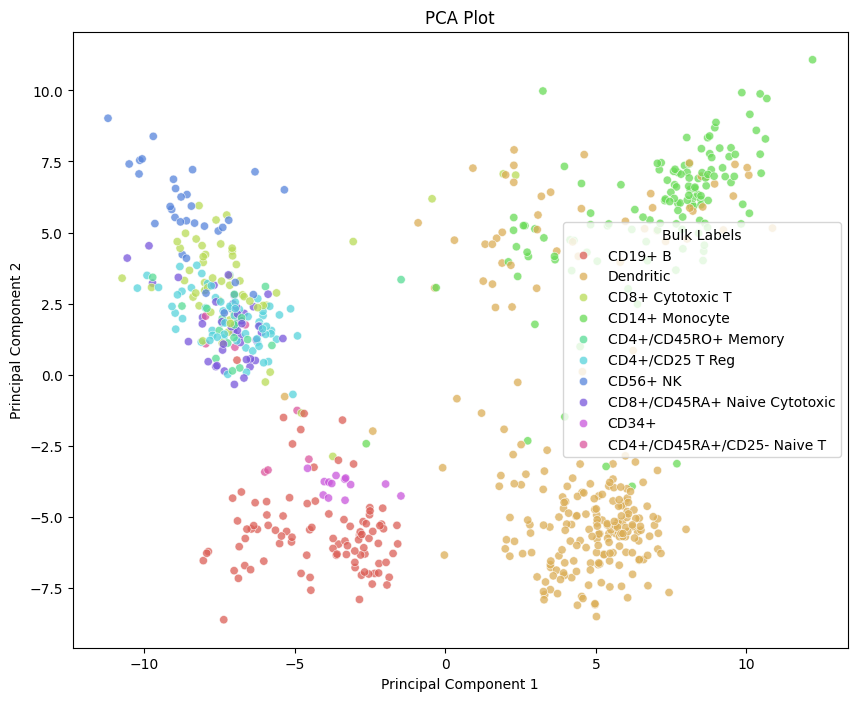

In [10]:
full_X = np.concatenate((train_X, test_X), axis=0)
full_y = np.concatenate((train_y, test_y), axis=0)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(full_X)
labels_str = full_y.astype(str).tolist()

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_str, palette='hls', alpha=0.75)
plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = scatter.legend()
legend.set_title('Bulk Labels')

plt.show()


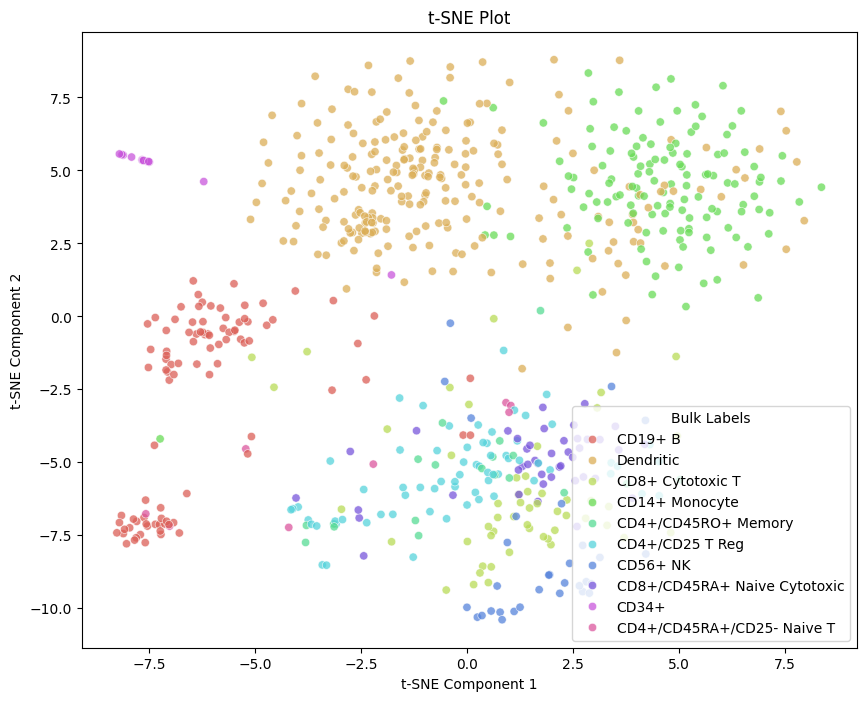

In [15]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(full_X)
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_str, palette='hls', alpha=0.75)
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
legend = scatter.legend()
legend.set_title('Bulk Labels')


plt.show()

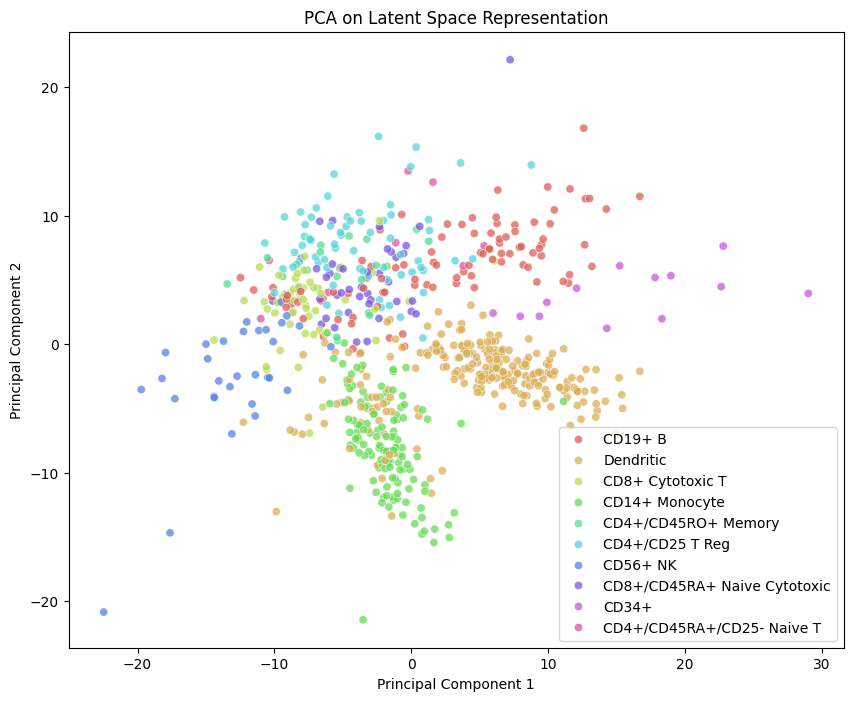

In [13]:
latent = model.encoder(X_tensor).detach().numpy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent)
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_str, palette='hls', alpha=0.75)
plt.title('PCA on Latent Space Representation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = scatter.legend()
legend.set_title('Bulk Labels')
plt.legend(loc='lower right')


plt.show()


:Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.